# Предсказание рейтинга ресторанов сайта TripAdvisor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline
plt.rcParams['figure.figsize'] = (10,7)

In [2]:
RANDOM_SEED = 42

### Дано

Датасет с информацией о ресторанах структуры:
    
0. `Restaurant_id` — идентификатор ресторана;
1. `City` — город;
2. `Cuisine Style` — разновидности кухни;
3. `Ranking` — место ресторана среди всех заведений города;
4. `Rating` — **рейтинг по данным TripAdvisor**;
5. `Price Range` — ценовой диапазон;
6. `Number of Reviews` — количество отзывов;
7. `Reviews` — данные о двух отзывах (содержание и дата);
8. `URL_TA` — URL страницы ресторана на сайте TripAdvisor;
9. `ID_TA` — идентификатор ресторана в БД TripAdvisor.

In [3]:
data = pd.read_csv('tripadvisor_restaurants.csv')

### Задача

Подготовить данные для построения модели предсказания рейтинга ресторанов таким образом, чтобы свести к минимуму ошибку в результатах работы модели.

### Очистка и преобразование признаков

In [4]:
display(data.sample(5))

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
11254,id_2131,Milan,NaN,2133.0,4.5,NaN,17.0,"[[], []]",/Restaurant_Review-g187849-d10535725-Reviews-I...,d10535725
308,id_332,Rome,"['Italian', 'Pizza', 'Mediterranean', 'Europea...",333.0,4.5,$$ - $$$,153.0,"[['Gem of a place!', 'Good food and great serv...",/Restaurant_Review-g187791-d12423010-Reviews-R...,d12423010
37973,id_652,Munich,"['Chinese', 'Asian', 'Vegetarian Friendly']",659.0,4.0,$$ - $$$,43.0,"[['Good, but bring a translator.', 'Good dim s...",/Restaurant_Review-g187309-d10106112-Reviews-L...,d10106112
25073,id_748,Oporto,"['European', 'Portuguese']",749.0,3.5,$$ - $$$,389.0,"[['The restaurant is popular', 'Absolute must-...",/Restaurant_Review-g189180-d1153789-Reviews-D_...,d1153789
12958,id_657,Milan,['Italian'],659.0,4.0,$,197.0,"[['Better than Dolmio Day', 'Enjoy as a local'...",/Restaurant_Review-g187849-d2308104-Reviews-Os...,d2308104


In [5]:
data.agg(['count', 'nunique'])\
    .append(pd.Series(data.isnull().sum(), name='null'))\
    .append(pd.Series(data.dtypes, name='dtype'))

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
count,40000,40000,30717,40000,40000,26114,37457,40000,40000,40000
nunique,11909,31,9007,11936,9,3,1459,33516,39980,39980
null,0,0,9283,0,0,13886,2543,0,0,0
dtype,object,object,object,float64,float64,object,float64,object,object,object


In [6]:
# пропуски в показателе количества отзывов считаем отсутствием таковых
data['Number of Reviews'].fillna(0, inplace=True)

In [7]:
from ast import literal_eval


# в значениях признаков разновидностей кухни и отзывов судя по всему
# строковые представления списков Python, поэтому мы можем их "вычислить",
# чтобы преобразовать в "настоящий" список

# заодно заполним пропуски разновидностей кухни предположением, о том
# что в таких заведениях подают обычную (неопределенную) еду
data['Cuisine Style'] = data['Cuisine Style'].fillna('["General"]').transform(literal_eval)

data['Reviews'] = data['Reviews'].str.replace('nan', 'None').fillna('[[], []]').transform(literal_eval)

In [8]:
data['Price Range'].value_counts(dropna=False)

$$ - $$$    18412
NaN         13886
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [9]:
# ценовой диапазон — ординальный признак, поэтому закодируем его числом
data['Price Range'] = data['Price Range'].map({'$': 0, '$$ - $$$': 1, '$$$$': 2})

# заполним пропуски медианным значением
data['Price Range'].fillna(data['Price Range'].median(), inplace=True)

In [10]:
# "вытащим" даты отзывов в отдельные признаки
reviews_dates = data['Reviews'].str[1].apply(pd.to_datetime)
reviews_dates = reviews_dates.apply(lambda dates: (dates.min(), dates.max()))
data[['Previous Review Date', 'Last Review Date']] = pd.DataFrame(reviews_dates.to_list(), index=data.index)

In [11]:
# и добавим показатель (в днях) того, насколько давно был оставлен
# последний отзыв, приняв за точку отсчета наиболее позднюю дату
last_review_ago = data['Last Review Date'].max() - data['Last Review Date']
data['Last Review Ago'] = last_review_ago.dt.days

# а также рассчитаем разницу в днях между двумя отзывами
reviews_interval = data['Last Review Date'] - data['Previous Review Date']
data['Days Between Reviews'] = reviews_interval.dt.days

# пропуски заполним максимальными значениями
data['Last Review Ago'].fillna(data['Last Review Ago'].max(), inplace=True)
data['Days Between Reviews'].fillna(data['Days Between Reviews'].max(), inplace=True)

### Анализ данных

Посмотрим на распределение ранга ресторанов

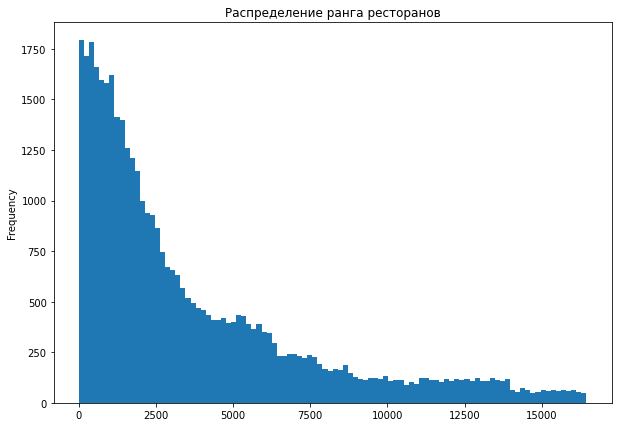

In [12]:
data['Ranking'].plot(kind='hist', bins=100, title='Распределение ранга ресторанов');

Неожиданно неровное распределение, ведь ранг — порядковый признак. Посмотрим с группировкой по городам.

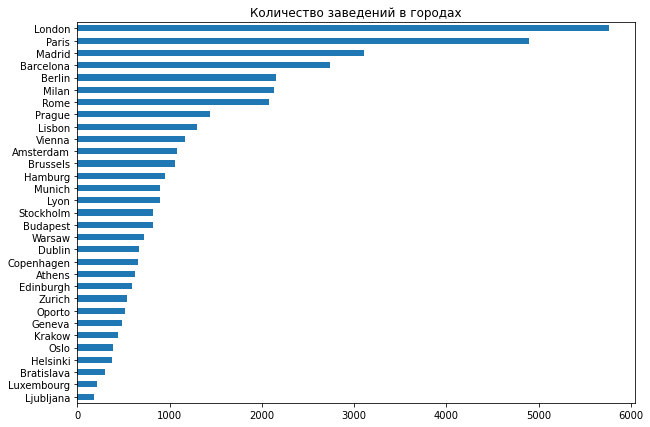

In [13]:
data['City'].value_counts(ascending=True).plot(kind='barh', title='Количество заведений в городах');

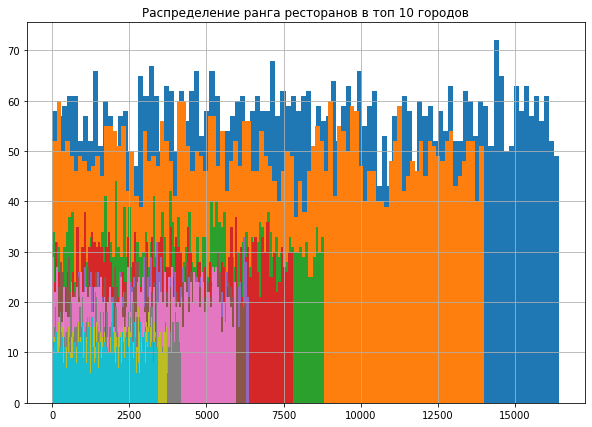

In [14]:
def feature_ingroup_distribution(df, by, feature, top_n=10, title=None):
    for val in (df[by].value_counts())[:top_n].index:
        df[feature][df[by] == val].hist(bins=100)
    plt.title(title)
    plt.show()


feature_ingroup_distribution(data, 'City', 'Ranking', title='Распределение ранга ресторанов в топ 10 городов')

Выходит, ранг заведения рассчитан в каждом городе в отдельности. Приведем тогда этот признак к одной шкале.

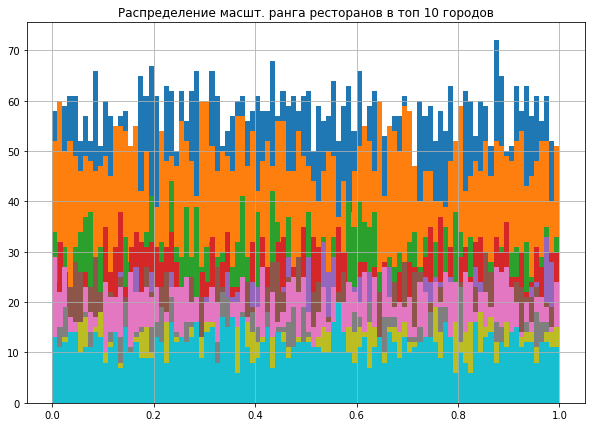

In [15]:
def scaled_feature(df, by, feature):
    feature_maxes = df.groupby(by)[feature].max()
    return df[[by, feature]].apply(lambda row: row[feature] / feature_maxes[row[by]], axis=1)


data['Scaled Ranking'] = scaled_feature(data, 'City', 'Ranking')

feature_ingroup_distribution(data, 'City', 'Scaled Ranking', title='Распределение масшт. ранга ресторанов в топ 10 городов')

Теперь всё 📏

Рассмотрим распределение целевой переменной

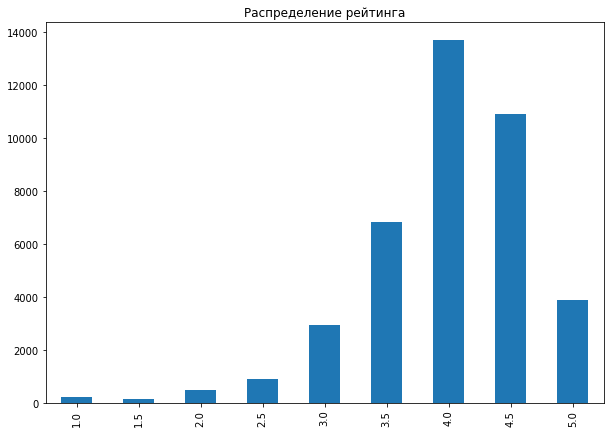

In [16]:
data['Rating'].value_counts().sort_index().plot(kind='bar', title='Распределение рейтинга');

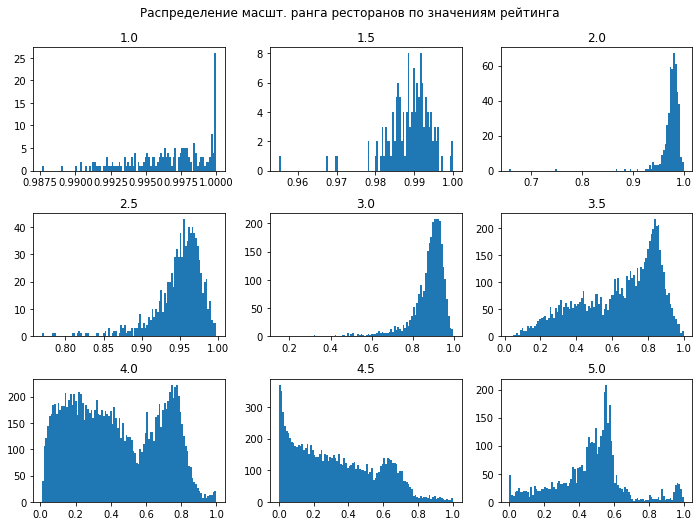

In [17]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(6.4*1.5, 4.8*1.5), constrained_layout=True)
fig.suptitle('Распределение масшт. ранга ресторанов по значениям рейтинга');

for i, rating in enumerate(sorted(data['Rating'].unique())):
    df_rr = data['Scaled Ranking'][data['Rating'] == rating]
    ax=axs[i//3, i%3]
    df_rr.plot(kind='hist', bins=100, ax=ax, title=rating)
    ax.set_ylabel(None)

Ранг (масштабированный) ресторанов распределен по-разному относительно рейтинга. Попробуем извлечь из этого наблюдения признак — средний рейтинг в группе (интервале) рангов заведений.

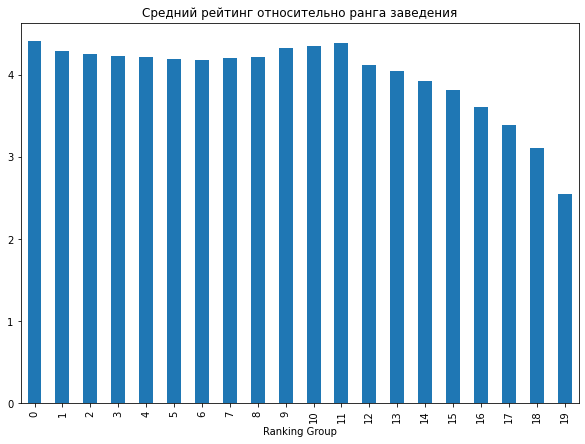

In [18]:
data['Ranking Group'] = pd.cut(data['Scaled Ranking'], 20).cat.codes

mean_rankgroups_rating = data.groupby('Ranking Group')['Rating'].mean()
data['Ranking Group Mean Rating'] = data['Ranking Group'].map(mean_rankgroups_rating)

mean_rankgroups_rating.plot(kind='bar', title='Средний рейтинг относительно ранга заведения');

В худшей трети рангов заведений рейтинг начинает быстро снижаться.

Рассмотрим теперь разновидности кухонь. Мы можем оценить разнообразие кухни ресторана в виде количества вариантов. Также посмотрим на признак полуярности кухни заведений.

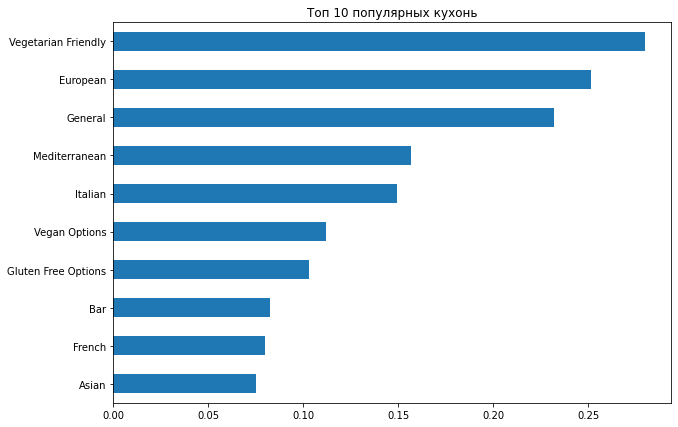

In [19]:
from collections import Counter
from itertools import chain


cs_cnt = Counter(chain.from_iterable(data['Cuisine Style']))
cuisine_styles = pd.Series(dict(cs_cnt.most_common()))
# рассчитаем долю каждой кухни среди всех заведений
cuisine_styles = cuisine_styles / data.shape[0]

cuisine_styles[:10].sort_values().plot(kind='barh', title='Топ 10 популярных кухонь');

# разнообразие кухонь, т. е. количество предлагаемых рестораном видов
data['Cuisine Options'] = data['Cuisine Style'].str.len()
# что-то вроде коэффициента покрытия заведением популярных кухонь
data['Cuisine Coverage'] = data['Cuisine Style'].apply(lambda row: cuisine_styles[row].sum() / cuisine_styles.sum())
# средняя популярность (всего предлагаемого разнообразия) кухни ресторана
data['Cuisine PopMean'] = data['Cuisine Style'].apply(lambda row: cuisine_styles[row].sum() / len(row))

🥬🌽🧄🍆🍠🧅🍅🥒🥔🥕🥦

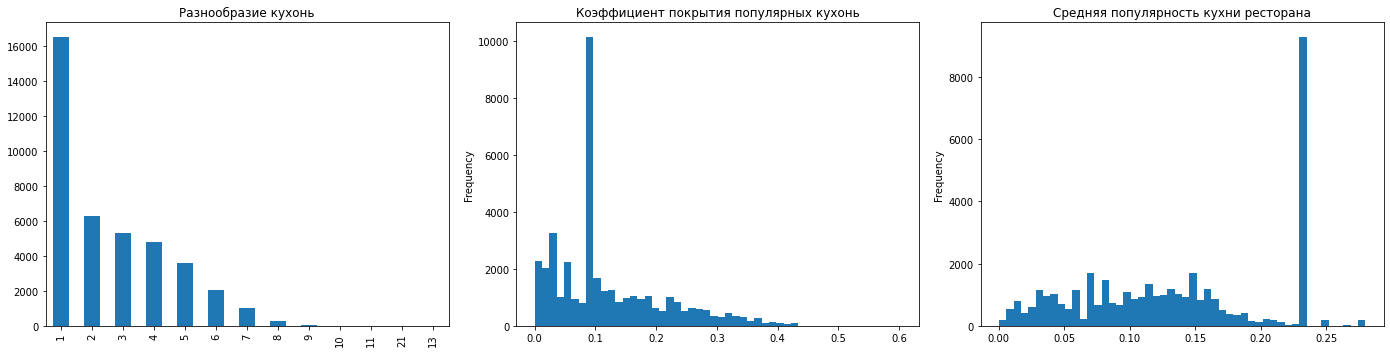

In [20]:
fig, axs = plt.subplots(ncols=3, figsize=(6.4*3, 4.8), constrained_layout=True)

data['Cuisine Options'].value_counts().plot(kind='bar', ax=axs[0], title='Разнообразие кухонь');
data['Cuisine Coverage'].plot(kind='hist', bins=50, ax=axs[1], title='Коэффициент покрытия популярных кухонь');
data['Cuisine PopMean'].plot(kind='hist', bins=50, ax=axs[2], title='Средняя популярность кухни ресторана');

Явно выделяется пропуск, который мы заполнили "обычной" кухней, но, кажется, это вполне соответствует действительности, поэтому оставим как есть.

Попробуем использовать также внешние данные о среде ресторанов (население города, туристический поток в страну, ВВП страны).

In [21]:
# cities population source - https://www.wolframalpha.com
cities_data = {
    'Paris'     : {'country': 'France'         , 'population': 2206000},
    'Stockholm' : {'country': 'Sweden'         , 'population': 932917},
    'London'    : {'country': 'United Kingdom' , 'population': 8670000},
    'Berlin'    : {'country': 'Germany'        , 'population': 3520000},
    'Munich'    : {'country': 'Germany'        , 'population': 1500000},
    'Oporto'    : {'country': 'Portugal'       , 'population': 249633},
    'Milan'     : {'country': 'Spain'          , 'population': 1370000},
    'Bratislava': {'country': 'Slovak Republic', 'population': 625167},
    'Vienna'    : {'country': 'Austria'        , 'population': 1870000},
    'Rome'      : {'country': 'Italy'          , 'population': 2870000},
    'Barcelona' : {'country': 'Spain'          , 'population': 1610000},
    'Madrid'    : {'country': 'Spain'          , 'population': 3170000},
    'Dublin'    : {'country': 'Ireland'        , 'population': 1280000},
    'Brussels'  : {'country': 'Belgium'        , 'population': 1110000},
    'Zurich'    : {'country': 'Switzerland'    , 'population': 372857},
    'Warsaw'    : {'country': 'Poland'         , 'population': 1750000},
    'Budapest'  : {'country': 'Hungary'        , 'population': 1760000},
    'Copenhagen': {'country': 'Denmark'        , 'population': 601448},
    'Amsterdam' : {'country': 'Netherlands'    , 'population': 851573},
    'Lyon'      : {'country': 'France'         , 'population': 506615},
    'Hamburg'   : {'country': 'Germany'        , 'population': 1790000},
    'Lisbon'    : {'country': 'Portugal'       , 'population': 545245},
    'Prague'    : {'country': 'Czech Republic' , 'population': 1270000},
    'Oslo'      : {'country': 'Norway'         , 'population': 658390},
    'Helsinki'  : {'country': 'Finland'        , 'population': 628208},
    'Edinburgh' : {'country': 'United Kingdom' , 'population': 446110},
    'Geneva'    : {'country': 'Switzerland'    , 'population': 198899},
    'Ljubljana' : {'country': 'Slovenia'       , 'population': 287218},
    'Athens'    : {'country': 'Italy'          , 'population': 664046},
    'Luxembourg': {'country': 'Luxembourg'     , 'population': 111287},
    'Krakow'    : {'country': 'Poland'         , 'population': 762448},
}

# countries gdp and tourism source - https://data.worldbank.org
worldbank_data = pd.read_csv('worldbank_popular.csv')

tourism_metric = 'International tourism, number of arrivals'
gdp_metric = 'GDP (current US$)'
year = '2018'

for city, city_features in cities_data.items():
    wb_country = worldbank_data[worldbank_data['Country Name'] == city_features['country']]
    city_features['gdp'] = float(wb_country[wb_country['Series Name'] == gdp_metric][year])
    city_features['tourism'] = float(wb_country[wb_country['Series Name'] == tourism_metric][year])

In [22]:
cities_df = pd.DataFrame(data['City'].map(cities_data).to_list()).drop('country', axis=1)
data = pd.concat([data, cities_df], axis=1)

### Корреляция признаков

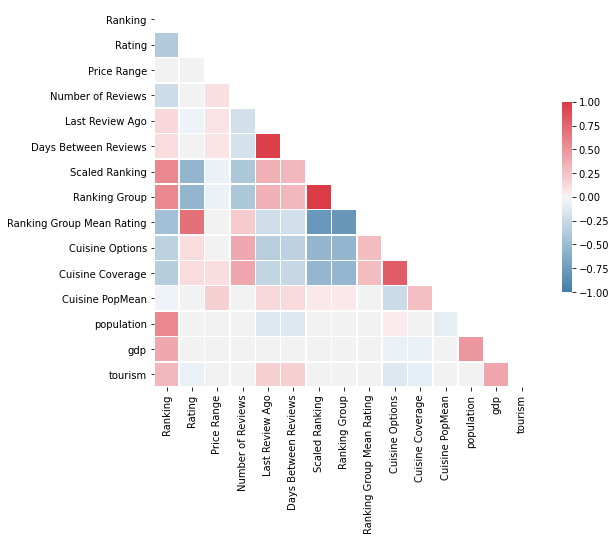

In [23]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap=sns.diverging_palette(240, 10, n=9, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, square=True, linewidths=.5, cbar_kws={"shrink": .5});

### Обучение модели

In [24]:
def prepare_model_data(df):
    features = [
        'Price Range',
        'Number of Reviews',
        'Last Review Ago',
        'Days Between Reviews',
        'Scaled Ranking',
#         'Ranking Group',
        'Ranking Group Mean Rating',
        'Cuisine Coverage',
#         'Cuisine PopMean',
        'Cuisine Options',
        'population',
        'gdp',
        'tourism'
    ]
    result = df[features]
    # разбавим датасет dummy переменными
    result = pd.concat([result, pd.get_dummies(df['City'])], axis=1)
    return result


X = prepare_model_data(data)
y = data['Rating'].values

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

model = RandomForestRegressor(n_estimators=100, verbose=0, n_jobs=-1, random_state=RANDOM_SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('MAE:', round(metrics.mean_absolute_error(y_test, y_pred), 4))

MAE: 0.2011


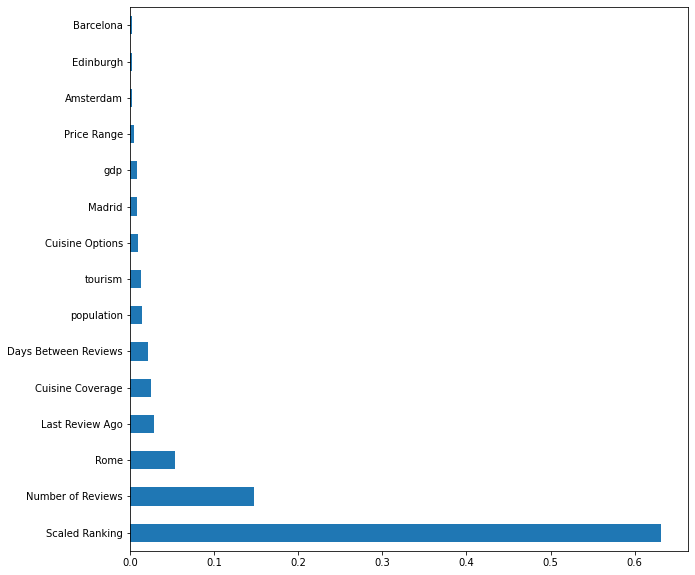

In [26]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');